In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

In [2]:
import gym, ray

from time import sleep
from pong import keep_ids

In [3]:
import torch
import torch.nn.functional as F

from torch import nn, optim

In [4]:
ray.init(object_store_memory=int(0.5 * 2 ** 30), redis_max_memory=int(0.5 * 2 ** 30))

2019-02-23 09:26:46,883	INFO node.py:278 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-02-23_09-26-46_7125/logs.
2019-02-23 09:26:46,996	INFO services.py:396 -- Waiting for redis server at 127.0.0.1:49996 to respond...
2019-02-23 09:26:47,117	INFO services.py:396 -- Waiting for redis server at 127.0.0.1:35036 to respond...
2019-02-23 09:26:47,119	INFO services.py:798 -- Starting Redis shard with 0.54 GB max memory.
2019-02-23 09:26:47,138	INFO services.py:1360 -- Starting the Plasma object store with 0.5368709119999999 GB memory using /dev/shm.



View the web UI at http://localhost:8889/notebooks/ray_ui.ipynb?token=655d684ea06d62f9e1435ecde176028590b6203e383b196a



{'node_ip_address': None,
 'redis_address': '192.168.1.21:49996',
 'object_store_address': '/tmp/ray/session_2019-02-23_09-26-46_7125/sockets/plasma_store',
 'webui_url': 'http://localhost:8889/notebooks/ray_ui.ipynb?token=655d684ea06d62f9e1435ecde176028590b6203e383b196a',
 'raylet_socket_name': '/tmp/ray/session_2019-02-23_09-26-46_7125/sockets/raylet'}

In [5]:
device = torch.device('cuda')

In [6]:
env = gym.make('Pong-ramDeterministic-v4')

In [7]:
n = env.observation_space.shape[0]
a = 3 #env.action_space.n

In [8]:
rom_action = lambda a: a if a == 0 else a + 2

In [9]:
groupop = lambda x, f, n=1: [f(x[i:i + n]) for i in range(0, len(x) - n, n)]

In [10]:
groupmean = lambda x, n=1: groupop(x, lambda x: sum(x) / len(x), n)

In [11]:
jtplot_style()

In [12]:
def weighted_sigmoid(x, mu=20, sigma=4, beta=5, zero_center=True):
    y = beta / (beta + np.exp(-x * sigma + mu))
    if zero_center: y -= weighted_sigmoid(0, mu, sigma, beta, zero_center=False)
    return y

In [13]:
def get_alpha(losses, mu=20, sigma=4, beta=5):
    return weighted_sigmoid(-np.log(losses / (2 * np.sqrt(feat_dim))), mu, sigma, beta)

Hyperparameters

In [14]:
n_steps = 7*10 ** 6
n_steps_test = 100
lr_actor = 1e-3
lr_critic = 1e-3
lr_icm = 1e-3
gamma = 0.99
tau = 20
n_workers = 16
chi = 1e-2
feat_dim = 8
eta = 0.1
beta = 0.2
alpha_pure = 0.0
alpha_icm = 1
icm_loss_decay = 0.01
icm_loss_threshold = 1.5

In [15]:
normalize = lambda x: (x / 127.5 - 1).astype(np.float32)

In [16]:
entropy = lambda x: (-(F.log_softmax(x, dim=-1) * F.softmax(x, dim=-1)).sum(-1)).mean()

In [17]:
def param_cast(params, device):
    for k, v in params.items():
        if isinstance(v, torch.Tensor):
            params[k] = v.to(device)
            
    return params

In [18]:
def one_hot(x, classes=None):
    if classes is None: classes = int(x.max().item()) + 1
    
    return torch.zeros(*x.shape, classes, device=device).scatter_(-1, x.unsqueeze(-1), 1.)

## Create Model

In [19]:
class Actor(nn.Sequential):
    def __init__(self):
        super().__init__(nn.Linear(n, 50), nn.SELU(), nn.Linear(50, a))
        self.device = torch.device('cpu')
        
    def to(self, *args, **kwargs):
        super().to(*args, **kwargs)
        self.device = next(self.children()).weight.data.device
        return self
    
    @torch.no_grad()
    def act(self, observation, probabilistic=True):
        if not torch.is_tensor(observation):
            observation = torch.tensor(observation, device=self.device)
            
        if not probabilistic: 
            return self(observation).max(dim=-1)[1].long()
        else:
            return torch.multinomial(F.softmax(self(observation), dim=-1), 1).long()
        
actor = Actor().to(device)

In [20]:
critic = nn.Sequential(nn.Linear(n, 50), nn.SELU(), nn.Linear(50, 1)).to(device)

In [21]:
class Featurizer(nn.Sequential):
    def __init__(self):
        super().__init__(nn.Linear(n, 100), nn.SELU(), nn.Linear(100, feat_dim))
    
    @torch.no_grad()
    def forward(self, x):
        return super().forward(x)
    
featurizer = Featurizer().to(device)

In [22]:
class ICM(nn.Sequential):
    def __init__(self):
        super().__init__(nn.Linear(n, 5), nn.ReLU(), nn.Linear(5, feat_dim))
        self.device = torch.device('cpu')
        
    def to(self, *args, **kwargs):
        super().to(*args, **kwargs)
        self.device = next(self.children()).weight.data.device
        return self
    
    @torch.no_grad()
    def get_reward(self, next_state):
        next_state = torch.tensor(next_state, device=self.device)
        
        return eta * self.forw_losses(next_state).item()
    
    def forw_losses(self, next_state):
        feats = featurizer(next_state); pred_feats = self(next_state)
        return 0.5 * torch.norm(pred_feats - feats, dim=-1)
    
icm = ICM().to(device)

In [23]:
optimizer_actor = optim.RMSprop(actor.parameters(), lr_actor)
optimizer_critic = optim.RMSprop(critic.parameters(), lr_critic)
optimizer_icm = optim.RMSprop(icm.parameters(), lr_icm)

In [24]:
@ray.remote
class Worker:
    def __init__(self):
        self.env = gym.make('Pong-ramDeterministic-v4')
        self.actor = Actor()
        self.done = True
        
    def run(self, parameters):
        self.actor.load_state_dict(parameters)
        
        states, actions, rewards = [], [], []
        
        if not self.done: states.append(self.state)
        while len(actions) < tau:
            if self.done:
                self.state = normalize(env.reset())
                states.clear(); actions.clear(); rewards.clear()
                states.append(self.state)
                
            action = self.actor.act(self.state).item()
            next_state, reward, self.done, _ = env.step(rom_action(action))
            self.state = normalize(next_state)
            states.append(self.state); actions.append(action); rewards.append(np.float32(reward))
            
        done = np.array(self.done, dtype=np.float32)
        return np.stack(states), np.stack(actions), np.stack(rewards), done

## Train

In [25]:
total_rewards = []
actor_losses = []
critic_losses = []
entropy_losses = []
icm_losses = []

In [26]:
def get_advantages(states, actions, rewards, dones):
    advantages = torch.zeros_like(rewards)
    
    optimizer_critic.zero_grad()
    
    # Remember to detach
    R = critic(states[:, -1]).squeeze(1).detach() * (1 - dones) # Returns
    
    for i in range(tau)[::-1]:
        R = rewards[:, i] + gamma * R
        advantages[:, i] = R - critic(states[:, i]).squeeze(1)
        
    return advantages

In [27]:
def train_actor_step(states, actions, advantages):
    optimizer_actor.zero_grad()
    action_scores = actor(states[:, :-1])
    # Remember to detach the advantages
    # We don't want the loss to affect the critic
    loss_actor = torch.mean(torch.stack([adv * F.cross_entropy(s, a, reduction='none')
                                         for s, a, adv in zip(action_scores.transpose(0, 1),
                                                              actions.t(),
                                                              advantages.detach().t())]))
    loss_entropy = entropy(action_scores)
    loss = loss_actor - chi * loss_entropy
    loss.backward()
    optimizer_actor.step()
    
    return loss_actor.item(), loss_entropy.item()

In [28]:
def train_critic_step(advantages):
    # Remember to detach the advantages
    # We don't want the loss to affect the critic
    loss_critic = F.mse_loss(advantages, torch.zeros_like(advantages))
    loss_critic.backward()
    optimizer_critic.step()
    
    return loss_critic.item()

In [29]:
def get_reward_from_loss(icm_loss, threshold=icm_loss_threshold):
    icm_rewards = icm_loss
    icm_rewards[icm_rewards / icm_mean_loss < threshold] = 0
    icm_rewards *=  eta
    return icm_rewards

In [30]:
def train_icm_step(states, actions):
    global icm_mean_loss
    
    optimizer_icm.zero_grad()
    next_states = states[:, 1:]
    
    forw_losses = icm.forw_losses(next_states)
    forw_loss = forw_losses.mean()
    loss_icm = forw_loss
    loss_icm.backward()
    optimizer_icm.step()
    
    icm_loss = forw_losses.detach()
    
    if icm_mean_loss is None: icm_mean_loss = icm_loss.mean().item()
    icm_mean_loss = icm_loss_decay * icm_loss.mean().item() + (1 - icm_loss_decay) * icm_mean_loss
    #print(f'decayed by {icm_loss.mean().item():.4f} go {icm_mean_loss:.4f}')
    icm_rewards = get_reward_from_loss(icm_loss)
    #print(f'%nonzero={len(icm_rewards.view(-1).nonzero()) / len(icm_rewards.view(-1)):.4f}')
    return loss_icm.item(), icm_rewards

In [31]:
def test_one_episode(n_steps, probabilistic=True, plot_icm=False, render=False):
    state = normalize(env.reset())
    done = False
    total_rewards = 0
    if type(plot_icm) is bool and plot_icm:
        icm_window=10
        icm_rewards = []
    elif type(plot_icm) is int: 
        icm_window=plot_icm;plot_icm = True;icm_rewards = []
    
    for step in range(n_steps):
        if render: env.render()
        action = actor.act(state, probabilistic).item()
        next_state, reward, done, _ = env.step(rom_action(action))
        next_state = normalize(next_state)
        if plot_icm: icm_rewards.append(icm.get_reward(next_state))
        if render and len(icm_rewards) > 1:
            if get_reward_from_loss(np.array(icm_rewards[-2:-1]) / eta)[0] > 1e-6:
                sleep(0.05)
            sleep(0.01)
        state = next_state
        total_rewards += reward
        if done: break
    
    if render: env.close()
    if plot_icm:
        icm_rewards = np.array(icm_rewards)
        plot(groupmean(icm_rewards, icm_window))
        plt.title(f'MSE: {((icm_rewards - icm_rewards.mean()) ** 2).mean():.2e}')
    
    return (total_rewards, icm_rewards) if plot_icm else total_rewards

In [32]:
# """
actor.load_state_dict(torch.load(DIR_NB / 'checkpoints' / 'actor.pt'))
critic.load_state_dict(torch.load( DIR_NB / 'checkpoints' / 'critic.pt'))
icm.load_state_dict(torch.load( DIR_NB / 'checkpoints' / 'icm.pt'))
optimizer_actor.load_state_dict(torch.load(DIR_NB / 'checkpoints' / 'actor-opt.pt'))
optimizer_critic.load_state_dict(torch.load( DIR_NB / 'checkpoints' / 'critic-opt.pt'))
optimizer_icm.load_state_dict(torch.load( DIR_NB / 'checkpoints' / 'icm-opt.pt'))
# """

-17.0


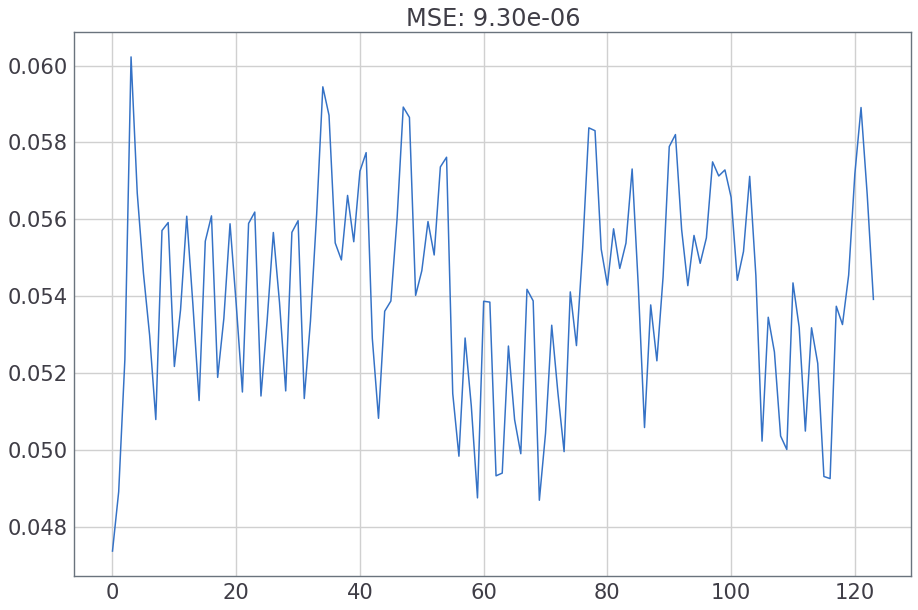

In [33]:
_, start_icm_loss = test_one_episode(10000, probabilistic=True, plot_icm=True)
print(_)
start_icm_loss /= eta

In [34]:
workers = [Worker.remote() for _ in range(n_workers)]

In [35]:
icm_mean_loss = None

In [36]:
pbar = tqdm(range(n_steps // (tau * n_workers)))
for step in pbar:
    params = ray.put(param_cast(actor.state_dict(), 'cpu'))
    results = ray.get([worker.run.remote(params) for worker in workers])

    states, actions, rewards, dones = [torch.tensor(np.stack(x), device=device)
                                       for x in zip(*results)]
    
    loss_icm, icm_rewards = train_icm_step(states, actions)
    rewards = alpha_icm * icm_rewards + alpha_pure * rewards
    advantages = get_advantages(states, actions, rewards, dones)

    loss_actor, loss_entropy = train_actor_step(states, actions, advantages)
    loss_critic = train_critic_step(advantages)

    if not step % 100:
        actor_losses.append(loss_actor)
        entropy_losses.append(loss_entropy)
        critic_losses.append(loss_critic)
        icm_losses.append(loss_icm)
        total_rewards.append(test_one_episode(n_steps_test))
        pbar.set_description(f'{total_rewards[-1]:.2f}')

2019-02-23 09:26:53,758	ERROR worker.py:1632 -- WARNING: 24 workers have been started. This could be a result of using a large number of actors, or it could be a consequence of using nested tasks (see https://github.com/ray-project/ray/issues/3644) for some a discussion of workarounds.


In [37]:
torch.save(actor.state_dict(), DIR_NB / 'checkpoints' / 'actor.pt')
torch.save(critic.state_dict(), DIR_NB / 'checkpoints' / 'critic.pt')
torch.save(icm.state_dict(), DIR_NB / 'checkpoints' / 'icm.pt')
torch.save(optimizer_actor.state_dict(), DIR_NB / 'checkpoints' / 'actor-opt.pt')
torch.save(optimizer_critic.state_dict(), DIR_NB / 'checkpoints' / 'critic-opt.pt')
torch.save(optimizer_icm.state_dict(), DIR_NB / 'checkpoints' / 'icm-opt.pt')

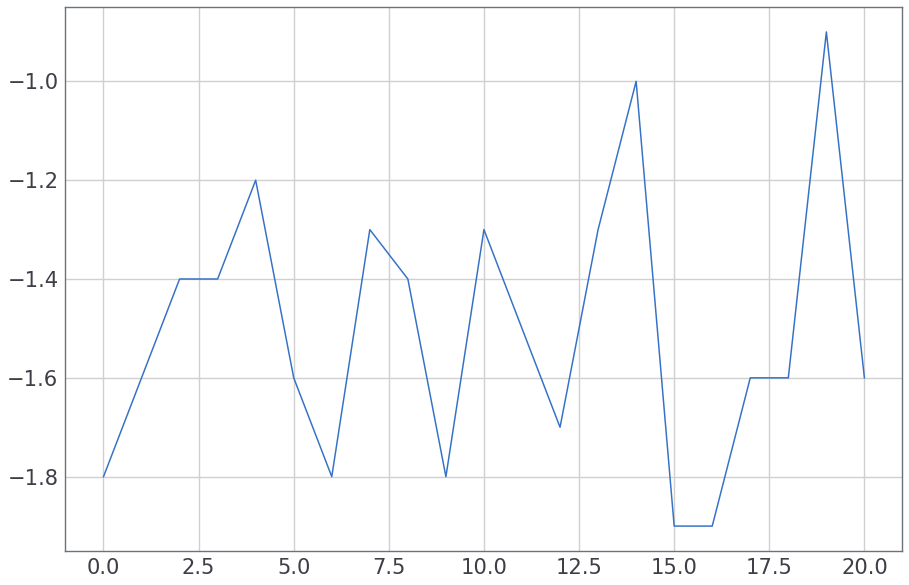

In [38]:
plot(groupmean(total_rewards, 10))

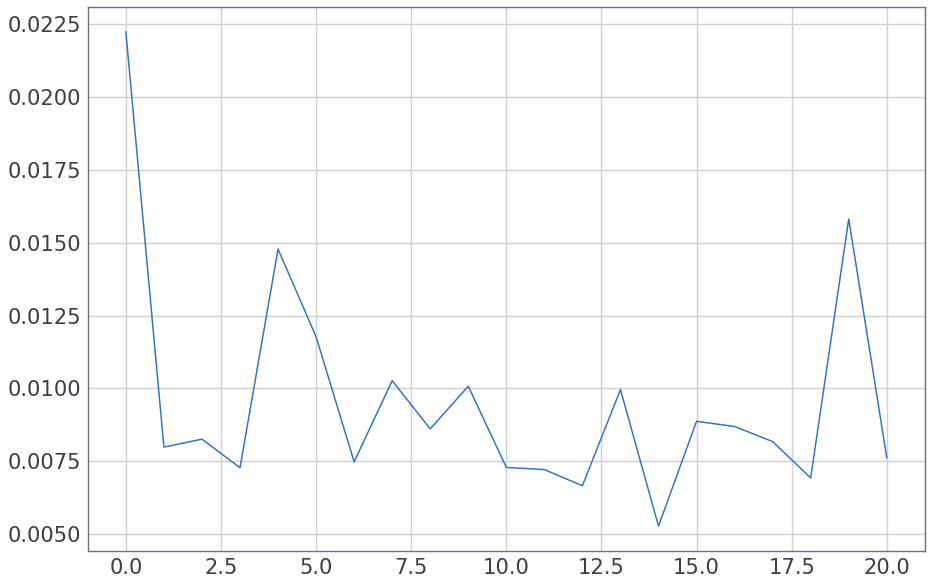

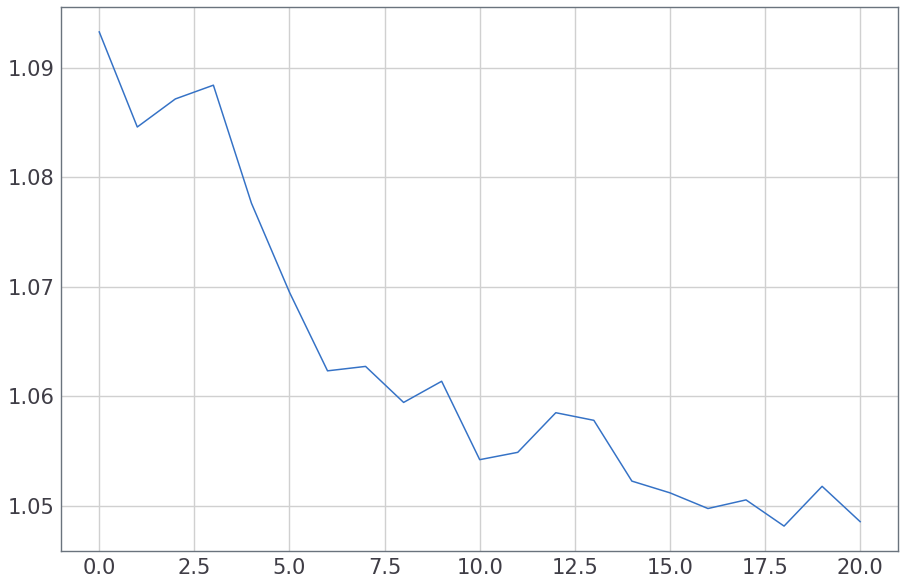

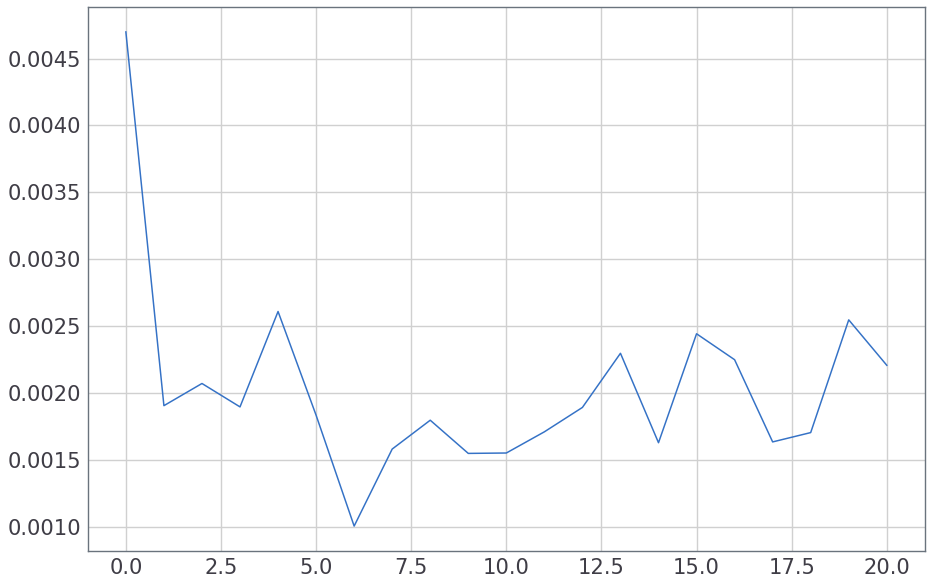

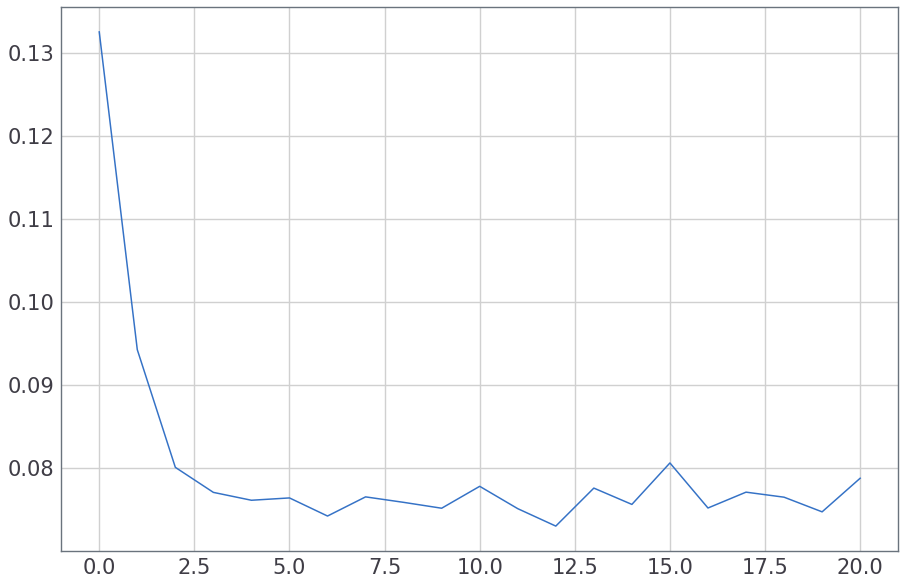

In [39]:
plot(groupmean(np.abs(actor_losses), 10)); plt.show()
plot(groupmean(np.abs(entropy_losses), 10)); plt.show()
plot(groupmean(critic_losses, 10)); plt.show()
plot(groupmean(icm_losses, 10)); plt.show()

-12.0

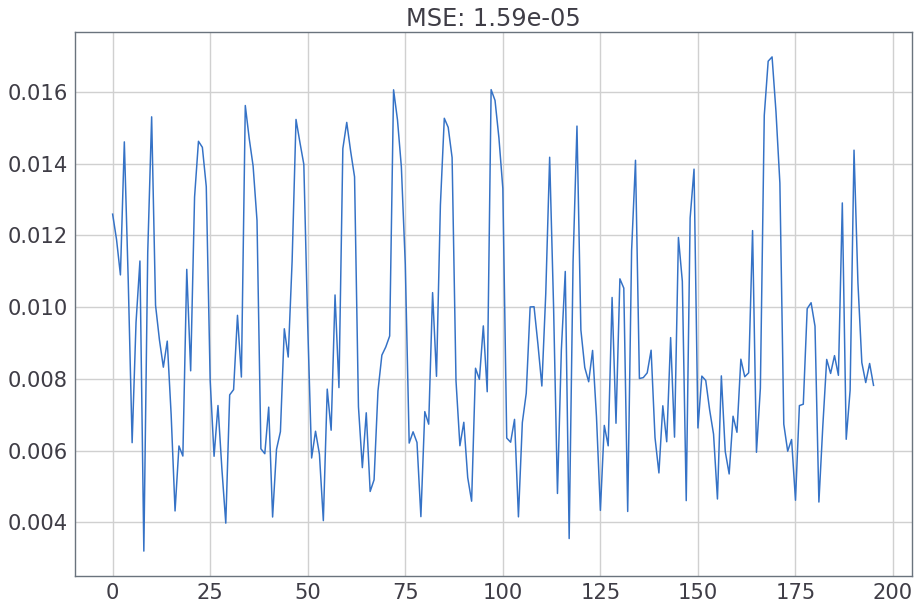

In [40]:
test_one_episode(10000, probabilistic=False, plot_icm=True)[0]

-19.0


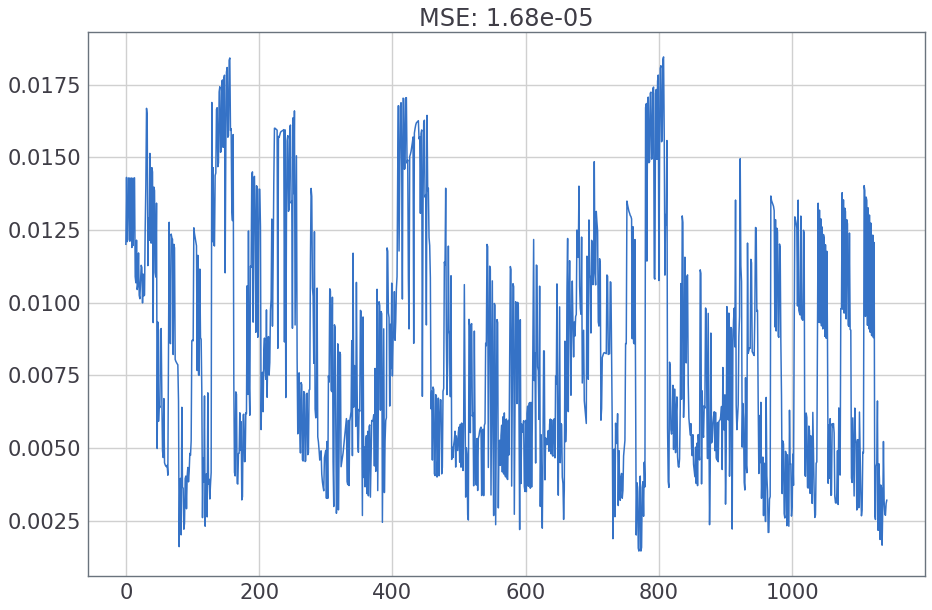

In [41]:
_, end_icm_loss = test_one_episode(10000, probabilistic=True, plot_icm=1)
print(_)
end_icm_loss /= eta

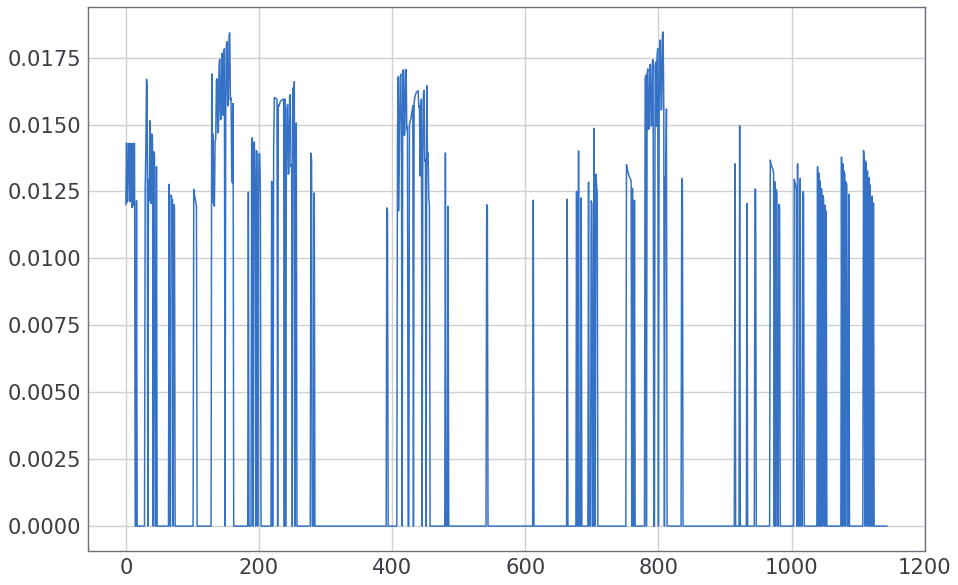

In [42]:
plot(get_reward_from_loss(end_icm_loss))

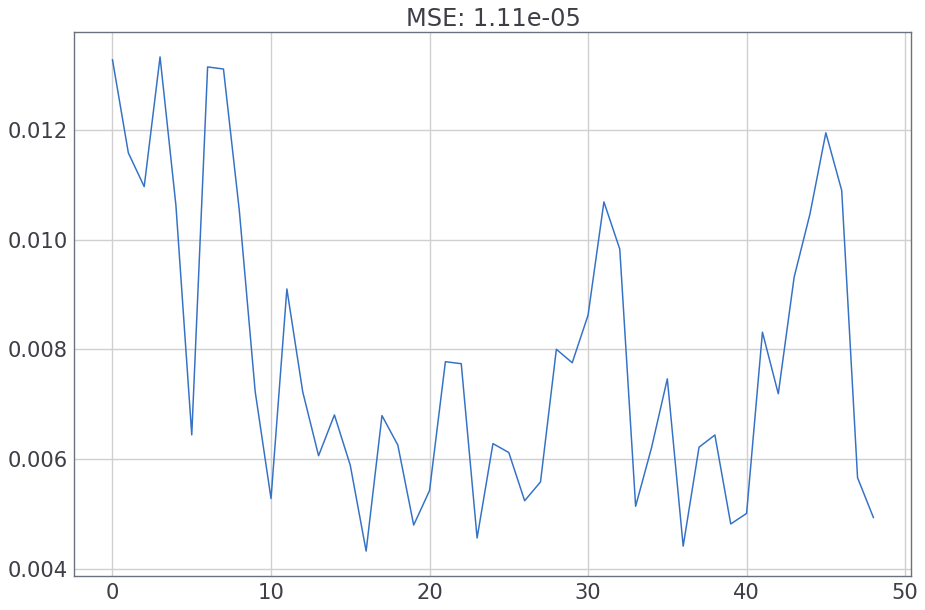

In [45]:
# Prevent cell (trail) from running when "Run All Cells" is pressed
if not 'dont_execute_cell' in globals():
    dont_execute_cell = False
    print('Run this cell once again')
else:
    test_one_episode(500, probabilistic=True, plot_icm=True, render=True)[0]